# Ready, Steady, Go AI (*Tutorial*)

This tutorial is a supplement to the paper, **Ready, Steady, Go AI: A Practical Tutorial on Explainable Artificial Intelligence and Its Applications in Plant Digital Phenomics** (submitted to *Patterns, 2021*) by Farid Nakhle and Antoine Harfouche

Read the accompanying paper [here](https://doi.org).

# Table of contents


* **1. Background**
* **2. Downloading Balanced Dataset**
* **3. Training RF**
* **4. Confusion Matrix**

# 1. Background


Before diving into image preprocessing or analysis, it is fundamental to understand how computers process an RGB image. The smallest element in an image is a dot called pixel, which is a mix of R, G, and B colors. Multiple pixels arranged in rows and columns form the image. However, computers do not understand pixels as dots of color, they only understand numbers, and thus, a pixel is denoted as 1 × 3 matrix, representing the three colors R, G, and B with each being an 8-bit integer leading to 256 possible states for every color. These states represent the brightness of each color, with 0 being the darkest and 255 being the brightest. For example, a matrix with values R = 255, G = 255 and B = 255 would lead to a white pixel.

**How Does Random Forest Work?**

A decision tree is an ML algorithm used for both classification and regression tasks. It has a tree-like structure with two types of nodes, decision and leaf nodes. Decision nodes represent a test that is applied on the input data, where a decision will be made based on its result. Leaf nodes are the final output of those decisions. They represent the final prediction and do not contain any further branches.

RF is an ML algorithm that employs multiple decision trees (a forest), creating an ensemble. Each tree in the ensemble is generated from a subset of the training set, with replacement (i.e., the same data can be sampled more than once), called the bootstrap sample. Lastly, RF determines the prediction by averaging the outputs of all decision trees for regression tasks, or by using majority voting for classification tasks.

We will use our split, balanced dataset to classify tomato healthy and diseased leafs


# 2. Downloading Balanced Dataset

As a reminder, we are working with the PlantVillage dataset, originally obtained from [here](http://dx.doi.org/10.17632/tywbtsjrjv.1).
For this tutorial, we will be working with a subset of PlantVillage, where we will choose the tomato healthy and diseased classes only. We have made the subset available [here](http://dx.doi.org/10.17632/4g7k9wptyd.1). 

The next code will automatically download the balanced dataset.

**It is important to note that Colab deletes all unsaved data once the instance is recycled. Therefore, remember to download your results once you run the code.**

In [ ]:
import requests
import os
import zipfile

## FEEL FREE TO CHANGE THESE PARAMETERS
dataset_url = "http://faridnakhle.com/pv/tomato-split-cropped-segmented-balanced.zip"
save_data_to = "/content/dataset/tomato-dataset/"
dataset_file_name = "tomato-split-cropped-segmented-balanced.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

r = requests.get(dataset_url, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})

print("Downloading dataset...")  

with open(save_data_to + dataset_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Dataset downloaded")  
print("Extracting files...")  
with zipfile.ZipFile(save_data_to + dataset_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)

## Delete the zip file as we no longer need it
os.remove(save_data_to + dataset_file_name)
print("All done!")  


Dataset downloaded
Extracting files...
All done!


# 3. Training RF

We will import sklearn as we will use it for the implementation of RF

In [ ]:
!pip install mahotas
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from PIL import Image

     |████████████████████████████████| 5.7MB 4.4MB/s 


In [ ]:
## YOU CAN CHANGE THESE VARIABLES    
# make a fix file size
img_size  = tuple((224,224))

#train path 
train_path = "/content/dataset/tomato-dataset/train/"
test_path = "/content/dataset/tomato-dataset/test/"
validation_path = "/content/data/tomato-dataset/val/"

# no of trees for trees in the forest
num_tree = 1000

# bins for image histograms 
bins = 8

# seed for reproducing same result 
seed = 4
######################################################

In [ ]:
# read the training data labels 
train_labels = os.listdir(train_path)
# sort the training labesl 
train_labels.sort()
print(train_labels)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
# get the testing data labels 
test_labels = os.listdir(test_path)
# sort the testing labesl 
test_labels.sort()
print(test_labels)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


Before training the random forest classifier, we need to extract features out of images using the functions defined above. In the next code block, we will loop over the images, passing each through the feature extraction functions and saving them in a global variable called global_features.

Then, we will repeat the same for the test set.

NOTE: Here, we do not need to vectorize the validation set as sklearn will be used to load the data_split function to validate the model while training.

**NB: To make running this notebook faster and our results easily reproducable, we made our trained models available and we will load them after this section. Thus, you might skip this next four code blocks**

In [ ]:
########################################################
## FUNCTION TO CALCULATE LEARNABLE FEATURES IN IMAGES ##
########################################################

# features description -1:  Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor -2 Haralick Texture 
def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

# feature-description -3 Color Histogram

def fd_histogram(image, mask=None):
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histog....
    return hist.flatten()

In [ ]:
# empty list to hold feature vectors and labels 
global_features = []
labels = []

i, j = 0, 0 
k = 0

# lop over the training data sub folder 
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    k = 1
    # loop over the images in each sub-folder
        
    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)
       
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        
        image = cv2.resize(image, img_size)
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)
                
        # Concatenate global features
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

        i += 1
        k += 1

    print("Processed folder: {}".format(current_label))

    j += 1

print("Completed Training Set Feature Extraction...")

Processed folder: Tomato___Bacterial_spot
Processed folder: Tomato___Early_blight
Processed folder: Tomato___Late_blight
Processed folder: Tomato___Leaf_Mold
Processed folder: Tomato___Septoria_leaf_spot
Processed folder: Tomato___Spider_mites Two-spotted_spider_mite
Processed folder: Tomato___Target_Spot
Processed folder: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Processed folder: Tomato___Tomato_mosaic_virus
Processed folder: Tomato___healthy
Completed Training Set Feature Extraction...


In [ ]:
# empty list to hold feature vectors and labels 
global_testing_features = []
testing_labels = []

i, j = 0, 0 
k = 0

%time
# lop over the testing data sub folder 

for testing_name in test_labels:
    # join the testing data path and each species testing folder
    dir = os.path.join(test_path, testing_name)

    # get the current training label
    current_label = testing_name

    k = 1
    # loop over the images in each sub-folder
        
    for file in os.listdir(dir):

        file = dir + "/" + os.fsdecode(file)
       
        # read the image and resize it to a fixed-size
        image = cv2.imread(file) 
        
        if image is not None:
            image = cv2.resize(image, img_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)

        # Concatenate global features
        global_testing_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        testing_labels.append(current_label)
        global_testing_features.append(global_testing_feature)

        i += 1
        k += 1
    print("Processed folder: {}".format(current_label))
    j += 1

print("Completed Testing Set Feature Extraction...")

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 7.87 µs
Processed folder: Tomato___Bacterial_spot
Processed folder: Tomato___Early_blight
Processed folder: Tomato___Late_blight
Processed folder: Tomato___Leaf_Mold
Processed folder: Tomato___Septoria_leaf_spot
Processed folder: Tomato___Spider_mites Two-spotted_spider_mite
Processed folder: Tomato___Target_Spot
Processed folder: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Processed folder: Tomato___Tomato_mosaic_virus
Processed folder: Tomato___healthy
Completed Testing Set Feature Extraction...


Next, we will save all the features extracted to a file so we can load them at anytime instead of repeating the task every time.

In [ ]:
####################
### TRAINING SET ###
####################

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

!mkdir /content/output/

# save the feature vector using HDF5
h5f_data = h5py.File('/content/output/training_data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('/content/output/training_labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("Extracted training set features are saved..")

####################
### TESTING  SET ###
####################
testingTargetNames = np.unique(testing_labels)
le = LabelEncoder()
testing_target = le.fit_transform(testing_labels)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_testing_features = scaler.fit_transform(global_testing_features)

# save the feature vector using HDF5
h5f_testing_data = h5py.File('/content/output/testing_data.h5', 'w')
h5f_testing_data.create_dataset('dataset_t', data=np.array(rescaled_testing_features))

h5f_testing_label = h5py.File('/content/output/testing_labels.h5', 'w')
h5f_testing_label.create_dataset('dataset_t', data=np.array(testing_target))

h5f_testing_data.close()
h5f_testing_label.close()

print("Extracted test set features are saved..")

**In the next section, we will load our extracted features to make our results reproducable. You can change the loading path to use your own instead**

In [ ]:
#############################
### DOWNLOAD THE Features ###
#############################

## FEEL FREE TO CHANGE THESE PARAMETERS
model_URL = "http://faridnakhle.com/pv/models/RF.zip"
save_data_to = "/content/models/"
model_file_name = "rf.zip"
#######################################

if not os.path.exists(save_data_to):
    os.makedirs(save_data_to)

print("Downloading model...")  

r = requests.get(model_URL, stream = True, headers={"User-Agent": "Ready, Steady, Go AI"})
with open(save_data_to + model_file_name, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024):
         if block: 
             file.write(block)

## Extract downloaded zip dataset file
print("Model downloaded")  
print("Extracting files...")

with zipfile.ZipFile(save_data_to + model_file_name, 'r') as zip_dataset:
    zip_dataset.extractall(save_data_to)
print("All done!")  

Model downloaded
Extracting files...
All done!


In [ ]:
# import the feature vector and trained labels
h5f_data = h5py.File('/content/models/training_data.h5', 'r')
h5f_label = h5py.File('/content/models/training_labels.h5', 'r')
global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']
global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

# import the testing feature vector and trained labels
h5f_testing_data = h5py.File('/content/models/testing_data.h5', 'r')
h5f_testing_label = h5py.File('/content/models/testing_labels.h5', 'r')
global_testing_features_string = h5f_testing_data['dataset_t']
global_testing_labels_string = h5f_testing_label['dataset_t']
global_testing_features = np.array(global_testing_features_string)
global_testing_labels = np.array(global_testing_labels_string)

In [ ]:
originalTrainingSet = np.array(global_features)
originalLabels = np.array(global_labels)
originalTestingSet = np.array(global_testing_features)
originalTestingLabel = np.array(global_testing_labels)

Now we can finally initate and train our random forest model

In [ ]:
clf  = RandomForestClassifier(n_estimators=num_tree, random_state = seed) 
clf.fit(originalTrainingSet, originalLabels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)

# Confusion Matrix

Now we will define a function to display the confusion matrix

In [ ]:
def cust_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #percentage: 
        cm = cm.astype('float') * 100
        # add percentage sign

    mycm = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    mycm.set_clim([0,100])

    cbar = plt.colorbar(mycm, shrink=0.82, ticks=list(range(0, 120, 20)))
    cbar.ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])  # vertically oriented colorbar

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,  ha="right")
    
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(format(cm[i, j], fmt)) + "%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        

    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams.update({'font.size': 12})
    plt.ylabel('True class', fontsize=17, fontweight='bold')
    plt.xlabel('Predicted class', fontsize=17, fontweight='bold')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


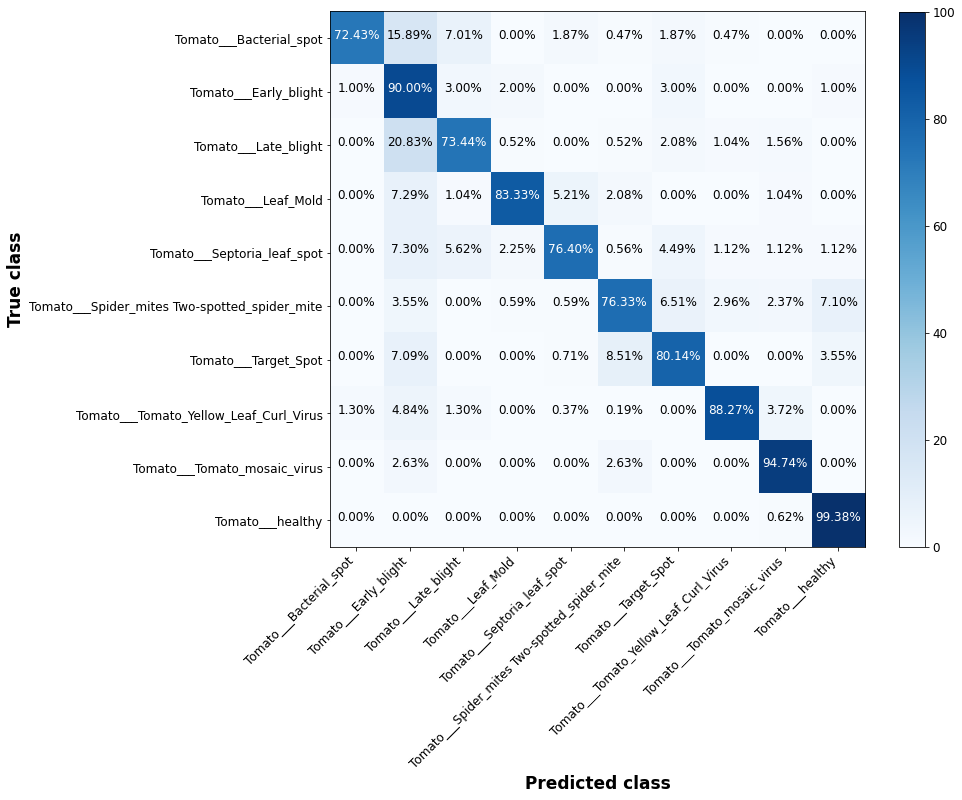

0.829041095890411

In [ ]:
from sklearn.metrics import confusion_matrix

clf_pred = clf.predict(originalTestingSet)
accuracy_score(originalTestingLabel, clf_pred)

cm = confusion_matrix(originalTestingLabel,clf_pred)
plt.figure(figsize=(12, 12))
cust_plot_confusion_matrix(cm, test_labels, True, 'Confusion matrix', cmap=plt.cm.Blues)
plt.show()
accuracy_score(originalTestingLabel, clf_pred)